## Goal: Adapt MNIST_SNN to CIFAR10
+ A Surrogate CNN and Backpropagation Through Time is used as described in snnTorch Tutorial 6
+ A non-spiking NN is trained on CIFAR10 (as provided by PyTorch) below for comparision.

In [ ]:
!pip install snntorch --quiet

In [ ]:
import torch, torch.nn as nn
import snntorch as snn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## DataLoading
Define variables for dataloading.

In [ ]:
batch_size = 128
subset = 1

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Torch Variables
dtype = torch.float

Load CIFAR dataset.

In [ ]:
#Define a Transform
transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
            ])

cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
cifar10_test = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

# test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


## Define Network with snnTorch. 

In [117]:
from snntorch import surrogate

beta = 0.9  # neuron decay rate 
spike_grad = surrogate.fast_sigmoid(slope = 15)
num_steps = 25

#  Initialize Network. To be Modified Later
net = nn.Sequential(nn.Conv2d(3, 12, 3),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 64, 3),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(64*6*6, 512),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Linear(512, 128),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Linear(128, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

## Define the Forward Pass

In [ ]:
from snntorch import utils 

data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

def forward_pass(net, num_steps, data):
    mem_rec = []
    spk_rec = []
    utils.reset(net)   # resets hidden states for all LIF neuron in net

    for step in range(num_steps):
        spk_out, mem_out = net(data)
        spk_rec.append(spk_out)
        mem_rec.append(mem_out)

    return torch.stack(spk_rec), torch.stack(mem_rec)

spk_rec, mem_rec = forward_pass(net, num_steps, data)
print(f"the shape of spk_rec is: {spk_rec.size()}")   # [25, batch_size, 10]

the shape of spk_rec is: torch.Size([1, 4, 10])


Define the optimizer and loss function.

In [ ]:
import snntorch.functional as SF

optimizer = torch.optim.Adam(net.parameters(), lr=2e-3, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

#alternative
#loss_fn = SF.ce_rate_loss()
#acc = SF.accuracy_rate(spk_rec, targets)

## Training Loop

In [ ]:
def batch_accuracy(train_loader, net, num_steps):
    #net.train()
    total = 0
    acc = 0

    train_loader = iter(train_loader)
    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device)
        spk_rec, _ = forward_pass(net, num_steps, data)

        acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1) 
        total += spk_rec.size(1)

        #print(SF.accuracy_rate(spk_rec, targets))
        #print(acc)
        #print(total)

    return acc/total

train_acc = batch_accuracy(train_loader, net, num_steps)
print(f"The total accuracy on the train set is: {train_acc * 100:.2f}%")

In [ ]:
# Training with Backpropagation Through Time (BPTT)
optimizer = torch.optim.AdamW(net.parameters(), lr=1e-3, betas=(0.9, 0.999))
num_epochs = 1 #10
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

for epoch in range(num_epochs):
    net.train()
    train_avg_loss = backprop.BPTT(net, train_loader, optimizer=optimizer, criterion=loss_fn,
                             num_steps=num_steps, time_var=False, device=device)

    train_loss_hist.append(train_avg_loss.item())
    print(f"Epoch {epoch}, Train Loss: {train_avg_loss.item():.2f}")

    train_acc = batch_accuracy(train_loader, net, num_steps)
    train_acc_hist.append(train_acc)
    print(f"Epoch {epoch}, Train Acc: {train_acc * 100:.2f}%")
        # Test set
    with torch.no_grad():
        net.eval()
        test_data, test_targets = next(iter(test_loader))
        test_data = test_data.to(device)
        test_targets = test_targets.to(device)

        test_spk_rec, test_mem_rec = forward_pass(net, num_steps, test_data)

        test_loss = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            test_loss = loss_fn(test_spk_rec, test_targets)
        test_loss_hist.append(test_loss.item())
        print(f"Epoch {epoch}, Test Loss: {test_loss.item():.2f}")

        test_acc = batch_accuracy(test_loader, net, num_steps)
        test_acc_hist.append(test_acc)
        print(f"Epoch {epoch}, Test Acc: {test_acc * 100:.2f}%\n")


In [ ]:
# Plot test accuracy
fig = plt.figure(facecolor="w")
plt.plot(train_acc_hist)
plt.plot(test_acc_hist)
plt.title("Accuracy Curves")
plt.legend(["Train Acc", "Test Acc"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

Training an a non-spiking NN on CIFAR10 (as provided by PyTorch)
We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

170499072it [00:25, 6680530.84it/s]                                


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


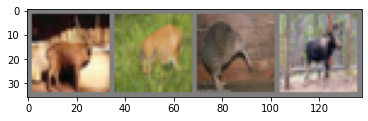

deer  deer  bird  deer 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

3. Define a Loss function and optimizer

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.228
[1,  4000] loss: 1.895
[1,  6000] loss: 1.691
[1,  8000] loss: 1.583
[1, 10000] loss: 1.520
[1, 12000] loss: 1.475
[2,  2000] loss: 1.393
[2,  4000] loss: 1.346
[2,  6000] loss: 1.357
[2,  8000] loss: 1.325
[2, 10000] loss: 1.302
[2, 12000] loss: 1.291
Finished Training


In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

5. Test the network on the test data

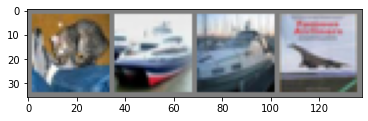

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   car   ship 


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %
